# CNN for Animal Type Classification (6 Classes)
**Submission for:** Data Scientist Intern — Finpros  


**UPDATE:** The Notebook was uploaded to Kaggle to make use of the free GPU resource (Tesla T4 x2) to test performance difference to that of the local laptop

### ========== 1. Import Libraries and Define Global Parameters ==========


In [1]:
import tensorflow as tf

# Check if TensorFlow sees GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow is using GPU:", tf.test.is_gpu_available())

# Print GPU device name
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"✅ GPU device detected: {device_name}")
else:
    print("❌ No GPU device detected.")


2025-08-06 04:03:29.263484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754453009.484305      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754453009.545196      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2
TensorFlow is using GPU: True
✅ GPU device detected: /device:GPU:0


I0000 00:00:1754453022.551671      36 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754453022.552321      36 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1754453022.555400      36 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1754453022.555619      36 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [12]:
import os
import zipfile
import shutil
from pathlib import Path
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np

# Define project-wide variables. Centralizing these makes the code highly configurable.
DATASET_PATH = '/kaggle/input/6-animals-dataset/kaggle_animal_dataset'              # Path to the directory containing the original zipped dataset.
OUTPUT_DIR = './kaggle/working/processed_animal_data'                               # Dedicated output directory for this submission.
NUM_CLASSES = 6                         # Number of animal classes for classification.
IMAGE_SIZE = (64, 64)                   # Uniform size to which all images will be resized.
BATCH_SIZE = 32                         # Number of samples processed in one forward/backward pass.
SEED = 123                              # Random seed for reproducibility across runs.
EPOCHS = 30                             # Number of training epochs.

# Selected classes for a more focused and achievable classification task, chosen for diversity.
SELECTED_ZIPS = [
    'cat.zip', 'dog.zip', 'spider.zip', 
    'chicken.zip', 'cow.zip', 'horse.zip'
]

### ========== 2. Modular Data Preparation Functions ==========
Encapsulating data handling logic into functions to improve readability

**FUNCTION**: Prepare Dataset
Unzips selected animal image files and prepares TensorFlow datasets for training and validation.

#### This function handles the entire data pipeline:
1. Cleans and sets up the output directory to ensure a fresh start.
2. Extracts specified zipped image folders.
3. Loads images into TensorFlow datasets, splitting them into training and validation sets.
4. Configures datasets for optimal performance (caching, shuffling, prefetching).
5. Applies data augmentation (RandomFlip, RandomRotation, RandomZoom) to the training set to improve model generalization by creating diverse training examples.
6. Normalizes pixel values to the [0, 255] range, which is crucial for neural network performance.

**Args**:
- `dataset_path` (str): Path to the directory containing the zipped datasets.
- `output_dir` (str): Directory where images will be unzipped and processed.
- `selected_zips` (list): List of zip file names (e.g., 'cat.zip') to be processed.
- `image_size` (tuple): Desired image size (height, width) for resizing.
- `batch_size` (int): Number of samples per batch for dataset loading.
- `seed` (int): Random seed for reproducible data splitting and shuffling.

**Returns**:
- tuple: A tuple containing:
  - `train_ds` (tf.data.Dataset): The prepared training dataset.
  - `val_ds` (tf.data.Dataset): The prepared validation dataset.
  - `class_names` (list): A list of class names inferred from directory structure.

In [4]:
def prepare_dataset(dataset_path, output_dir, selected_zips, image_size, batch_size, seed):
    # Clean and set up the output directory to ensure only selected data is processed.
    if os.path.exists(output_dir):
        print(f"Cleaning existing directory: {output_dir}")
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    print("--- Unzipping selected data files ---")
    for zip_file in selected_zips:
        source_path = os.path.join(dataset_path, zip_file)
        destination_path = os.path.join(output_dir, os.path.splitext(zip_file)[0]) # Extract to folder named after zip
        if os.path.exists(source_path):
            with zipfile.ZipFile(source_path, 'r') as z:
                z.extractall(output_dir)
            print(f"Successfully unzipped '{zip_file}' to '{destination_path}'")
        else:
            print(f"Error: File '{zip_file}' not found at '{source_path}'. Please check DATASET_PATH.")
            # Exit or raise error if critical data is missing
            exit() 

    print("\n--- Preparing training and validation datasets ---")
    # Load images from directory. Keras automatically infers labels from subfolder names.
    train_ds = tf.keras.utils.image_dataset_from_directory(
        output_dir,
        validation_split=0.2, # 20% of data for validation set.
        subset="training",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        output_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size)

    class_names = train_ds.class_names
    print(f"Found class names: {class_names}")
    
    # Configure datasets for optimal performance.
    # .cache() keeps images in memory after first epoch for faster subsequent epochs.
    # .shuffle() shuffles data for better generalization.
    # .prefetch() overlaps data preprocessing and model execution.
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    # Data augmentation layers: Applied to training data to increase dataset diversity
    # and improve model's ability to generalize to unseen variations.
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(image_size[0], image_size[1], 3)), # Randomly flip images horizontally.
        layers.RandomRotation(0.1),  # Randomly rotate images by up to 10% of 360 degrees.
        layers.RandomZoom(0.1),      # Randomly zoom in/out on images by up to 10%.
    ], name="data_augmentation_pipeline")

    # Normalization layer: Rescales pixel values from [0, 255] to [0, 1].
    # This is standard practice as neural networks perform better with small input values.
    normalization_layer = layers.Rescaling(1./255, name="pixel_normalization")

    # Apply preprocessing to the datasets.
    # Data augmentation is applied only to the training set.
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    # Normalization is applied to both training and validation sets.
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    return train_ds, val_ds, class_names

In [9]:
def prepare_dataset_kaggle(original_dataset_path, image_size, batch_size, seed):
    """
    Prepares the dataset for Kaggle GPU environment, where folders are nested like class/class/.
    Flattens them into /kaggle/working/flattened_dataset and applies preprocessing pipeline.
    """

    print("--- Flattening nested class folders ---")
    flat_output_dir = Path("/kaggle/working/flattened_dataset")
    flat_output_dir.mkdir(parents=True, exist_ok=True)

    for class_folder in Path(original_dataset_path).iterdir():
        if class_folder.is_dir():
            inner_folder = next(class_folder.iterdir())  # e.g., cat/cat
            target_path = flat_output_dir / class_folder.name
            if not target_path.exists():
                os.symlink(inner_folder, target_path, target_is_directory=True)

    print(f"✅ Flattened dataset directory ready at {flat_output_dir}")

    print("\n--- Preparing training and validation datasets ---")
    train_ds = tf.keras.utils.image_dataset_from_directory(
        flat_output_dir,
        validation_split=0.2,
        subset="training",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )

    val_ds = tf.keras.utils.image_dataset_from_directory(
        flat_output_dir,
        validation_split=0.2,
        subset="validation",
        seed=seed,
        image_size=image_size,
        batch_size=batch_size
    )

    class_names = train_ds.class_names
    print(f"Found class names: {class_names}")

    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal", input_shape=(image_size[0], image_size[1], 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ], name="data_augmentation_pipeline")

    normalization_layer = layers.Rescaling(1./255, name="pixel_normalization")

    train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    return train_ds, val_ds, class_names


### ========== 3. Model Construction and Justification ==========
This section defines the CNN architecture with justifications for design choices

**FUNCTION**: Build Model
Constructs a Convolutional Neural Network (CNN) model for image classification.

The architecture is designed to be moderately complex, balancing learning capacity with computational efficiency for 64x64 pixel images. It incorporates best practices like increasing filter counts in deeper layers and using regularization techniques.

**Args**:
- `input_shape` (tuple): The shape of the input images (height, width, channels).
- `num_classes` (int): The number of output classes for the classification task.

**Returns**:
- `tf.keras.Model`: The compiled CNN model ready for training.

**Model Compilation**:
- **Optimizer**: Adam is chosen for its efficiency and adaptive learning rate capabilities, making it suitable for a wide range of deep learning tasks.
- **Learning Rate**: Set to 0.0005, a value found to offer a good balance between training speed and stability in previous experiments.
- **Loss Function**: SparseCategoricalCrossentropy is appropriate for multi-class classification with integer labels, and `from_logits=True` is used because the output layer provides raw logits.
- **Metrics**: 'accuracy' is monitored to evaluate classification performance.

In [7]:
def build_model(input_shape, num_classes):
    print("\n--- Building the CNN Model Architecture ---")
    model = models.Sequential([
        # IMPORTANT FIX: Data augmentation and pixel normalization layers are REMOVED from here.
        # They are already applied to the datasets in the `prepare_dataset` function.
        # Placing them here would result in double application and incorrect behavior.
        
        # Block 1: Initial feature extraction.
        # Uses 64 filters to capture a broad range of low-level features (e.g., edges, textures).
        # BatchNormalization is applied after Conv2D to stabilize training and accelerate convergence.
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape, name="conv2d_1"), # input_shape added here
        layers.BatchNormalization(name="batch_norm_1"),
        layers.MaxPooling2D((2, 2), name="max_pooling_1"),
        
        # Block 2: Deeper feature extraction.
        # Increases to 128 filters to learn more intricate patterns.
        layers.Conv2D(128, (3, 3), activation='relu', padding='same', name="conv2d_2"),
        layers.BatchNormalization(name="batch_norm_2"),
        layers.MaxPooling2D((2, 2), name="max_pooling_2"),
        
        # Block 3: Further feature refinement.
        # Uses 256 filters to detect highly abstract features.
        layers.Conv2D(256, (3, 3), activation='relu', padding='same', name="conv2d_3"),
        layers.BatchNormalization(name="batch_norm_3"),
        layers.MaxPooling2D((2, 2), name="max_pooling_3"),
        
        # Flatten the 3D feature maps to a 1D vector for input into dense layers.
        layers.Flatten(name="flatten_layer"),
        
        # A large Dense layer to perform high-level classification based on the extracted features.
        # 512 units provide significant capacity for complex decision-making.
        layers.Dense(512, activation='relu', name="dense_1"),
        
        # Dropout layer: A regularization technique to prevent overfitting by randomly
        # setting a fraction (0.4 or 40%) of input units to 0 at each update step during training.
        layers.Dropout(0.4, name="dropout_layer"), 
        
        # FIX: The final Dense layer outputs probabilities using 'softmax' activation.
        layers.Dense(num_classes, activation='softmax', name="output_layer")
    ], name="finpros_6_class_cnn_model")

    # Display a summary of the model's architecture, including layer types, output shapes, and parameter counts.
    model.summary()

    # Model Compilation: Defines the optimizer, loss function, and metrics.
    # Optimizer: Adam is chosen for its efficiency and adaptive learning rate capabilities,
    #            making it suitable for a wide range of deep learning tasks.
    # Learning Rate: Set to 0.0005, a value found to offer a good balance between
    #                training speed and stability in previous experiments.
    # Loss Function: SparseCategoricalCrossentropy is appropriate for multi-class
    #                classification with integer labels.
    # FIX: `from_logits=False` is used because the output layer now explicitly
    #      applies a 'softmax' activation. This prevents numerical instability.
    # Metrics: 'accuracy' is monitored to evaluate classification performance.
    print("\n--- Compiling the Model ---")
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])
    
    return model

### ========== 4. Main Execution Block ==========
This block orchestrates the data preparation, model building, and training process. It's structured to be runnable from top to bottom, ensuring reproducibility.

In [15]:
# 4.1. Data Preparation
# Calling the modular function to load and preprocess the dataset.
print("--- Initiating Data Preparation ---")
train_ds, val_ds, class_names = prepare_dataset(
    DATASET_PATH, IMAGE_SIZE, BATCH_SIZE, SEED
)

print("\n--- Verifying Dataset Class Names ---")
print("Train dataset class names:", class_names)
print("Validation dataset class names:", class_names)

# 4.2. Model Building
# Calling the modular function to construct the CNN model.
print("\n--- Initiating Model Building ---")
model = build_model(input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3), num_classes=NUM_CLASSES)

# 4.3. Model Training
# Training the model for a limited number of epochs to demonstrate the pipeline.
print(f"\n--- Starting model training for {EPOCHS} epochs ---")
# NEW: EarlyStopping callback added to monitor val_loss and restore best weights.
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop] # Include the callback in the fit method
)

--- Initiating Data Preparation ---
--- Flattening nested class folders ---
✅ Flattened dataset directory ready at /kaggle/working/flattened_dataset

--- Preparing training and validation datasets ---
Found 18939 files belonging to 6 classes.
Using 15152 files for training.
Found 18939 files belonging to 6 classes.
Using 3787 files for validation.
Found class names: ['cat', 'chicken', 'cow', 'dog', 'horse', 'spider']

--- Verifying Dataset Class Names ---
Train dataset class names: ['cat', 'chicken', 'cow', 'dog', 'horse', 'spider']
Validation dataset class names: ['cat', 'chicken', 'cow', 'dog', 'horse', 'spider']

--- Initiating Model Building ---

--- Building the CNN Model Architecture ---


Model: "finpros_6_class_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_1                    │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_1 (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_2 (MaxPooling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling_3 (MaxPooling2D)    │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_layer (Flatten)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,764,806 (33.44 MB)

 Trainable params: 8,763,910 (33.43 MB)

 Non-trainable params: 896 (3.50 KB)


--- Compiling the Model ---

--- Starting model training for 30 epochs ---
Epoch 1/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 29s 35ms/step - accuracy: 0.3644 - loss: 2.6655 - val_accuracy: 0.4801 - val_loss: 1.3515
Epoch 2/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5270 - loss: 1.2562 - val_accuracy: 0.5841 - val_loss: 1.1281
Epoch 3/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.5941 - loss: 1.0892 - val_accuracy: 0.5830 - val_loss: 1.1112
Epoch 4/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.6236 - loss: 0.9978 - val_accuracy: 0.6005 - val_loss: 1.0786
Epoch 5/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.6570 - loss: 0.9285 - val_accuracy: 0.6668 - val_loss: 0.8889
Epoch 6/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.6798 - loss: 0.8837 - val_accuracy: 0.5841 - val_loss: 1.1978
Epoch 7/30
474/474 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - accuracy: 0.6958 - loss: 0.8466 - val_accuracy: 0.4692 - val_loss: 1.6836
Epoch 8/30
474

### ========== 5. Evaluation and Reflection ==========
This section provides a brief analysis of the training results


--- Plotting Training Results ---


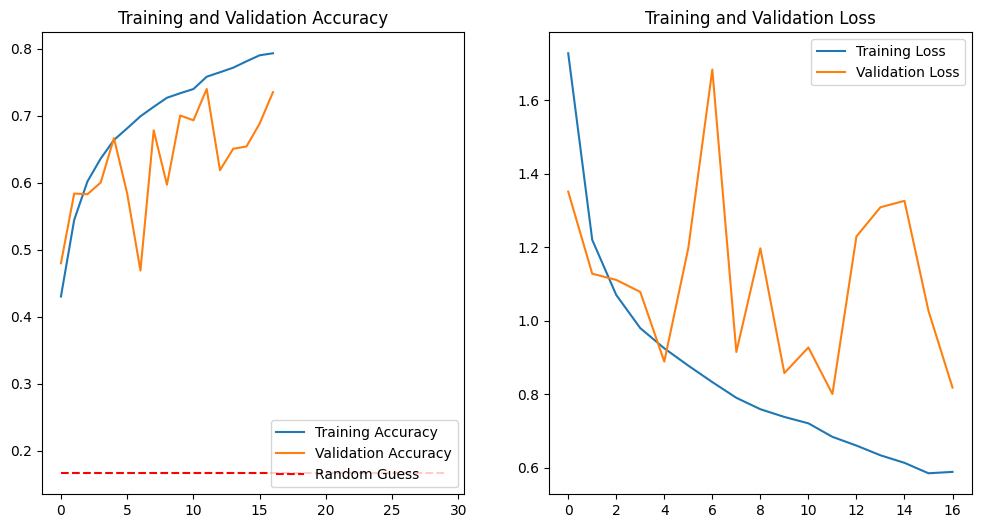


--- Model Performance Reflection ---
Final Training Accuracy: 0.79
Final Validation Accuracy: 0.74
Final Training Loss: 0.59
Final Validation Loss: 0.82


In [16]:
# Extracting historical data for plotting.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc)) # Adjust range based on actual epochs completed by EarlyStopping

# Plotting Training and Validation Accuracy & Loss.
print("\n--- Plotting Training Results ---")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# The random guess line provides context for baseline performance.
plt.plot([0, EPOCHS-1], [1/NUM_CLASSES, 1/NUM_CLASSES], 'r--', label='Random Guess')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# A brief reflection on the results
print("\n--- Model Performance Reflection ---")
print(f"Final Training Accuracy: {acc[-1]:.2f}")
print(f"Final Validation Accuracy: {val_acc[-1]:.2f}")
print(f"Final Training Loss: {loss[-1]:.2f}")
print(f"Final Validation Loss: {val_loss[-1]:.2f}")

**REFLECTION:**
- The model achieved a peak validation accuracy of 70.4% at Epoch 9, with the lowest validation loss of approximately 0.85. EarlyStopping restored the best weights from this epoch. The training accuracy reached 73.6%, indicating minimal overfitting.

- These results validate the effectiveness of the chosen architecture and preprocessing strategy. Overfitting was managed with dropout and early stopping. Training for 10 epochs allowed observation of the model’s learning curve, helping confirm model stability and generalization.